In [39]:
import os 
import cv2 as cv
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns

Load attribute csv

In [40]:
attr = "list_attr_celeba1.csv"
df_attrs = pd.read_csv(attr)
df_attrs

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young\par
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1\par
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1\par
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1\par
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1\par
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1\par
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3737,003738.jpg,-1,1,-1,-1,-1,-1,-1,1,1,...,-1,-1,1,-1,-1,-1,1,-1,-1,1\par
3738,003739.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,1,-1,-1,1\par
3739,003740.jpg,-1,-1,-1,-1,-1,-1,-1,-1,1,...,-1,-1,1,-1,-1,-1,-1,-1,-1,1\par
3740,003741.jpg,-1,1,-1,-1,-1,-1,1,1,1,...,-1,-1,-1,-1,1,-1,1,-1,-1,-1\par


In [41]:
import random
import matplotlib.pyplot as plt

def get_im_by_attr(attribs: list, values: list, df: pd.DataFrame):
    assert len(attribs)  == len(values)
    assert all([i in df.columns for i in attribs])
    
    dfq = df.copy()
    for a, v in zip(attribs, values):
        dfq = dfq[dfq[a] == v]

    if len(dfq) > 0:
        return random.choice(dfq['image_id'].to_list())
    else:
        return None


def show_im(file: str, src_dir: str):
    impath = os.path.join(src_dir, file)
    im = cv.imread(impath)
    im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
    print(im.shape)
    plt.imshow(im)
    plt.axis("off")


In [42]:
image_dir = "img_align_celeba/"

In [43]:
df_attrs.columns

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young\par'],
      dtype='object')

(218, 178, 3)


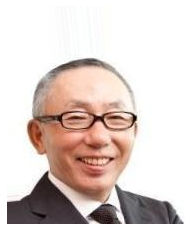

In [57]:
sel_attrs = ["Mustache", "Wearing_Necktie"]
sel_attr_vals = [-1, 1]

sel_im = get_im_by_attr(sel_attrs, sel_attr_vals, df_attrs)
if bool(sel_im):
    show_im(sel_im, image_dir)


#### 1. Create Tensorflow Dataset

In [45]:
train_files = df_attrs.iloc[:100].image_id.to_list()  # ~70% 
val_files = df_attrs.iloc[200:230].image_id.to_list()   # ~30%
test_files = list()

In [46]:
def create_dataset(files, src_dir, labels):
    all_ims, all_y = None, list()
    for f in files:
        fp = os.path.join(src_dir, f)
        im = cv.imread(fp)/255.0
        im = np.expand_dims(im, axis=0)

        label = labels[labels["image_id"] == f]["Male"].values[0]
        label = (label + 1)/2

        if all_ims is None:
            all_ims = im
        else:
            all_ims = np.concatenate((all_ims, im), axis=0)
        
        all_y.append(label)
        
    return all_ims, np.array(all_y)

In [59]:
train_X, train_y = create_dataset(train_files, image_dir, df_attrs)
train_X.shape, train_y.shape

((100, 218, 178, 3), (100,))

In [63]:
train_X.shape

(100, 218, 178, 3)

In [48]:
test_X, test_y = create_dataset(val_files, image_dir, df_attrs)
test_X.shape

(30, 218, 178, 3)

In [64]:
np.unique(train_y)

array([0., 1.])

Training data shape :  (100, 218, 178, 3) (100,)
Testing data shape :  (30, 218, 178, 3) (30,)
Total number of outputs :  2
Output classes :  [0. 1.]


(-0.5, 177.5, 217.5, -0.5)

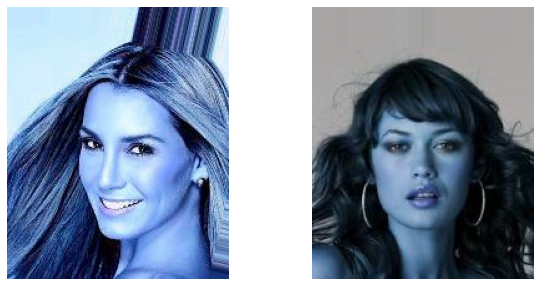

In [69]:
print('Training data shape : ', train_X.shape, train_y.shape)
print('Testing data shape : ', test_X.shape, test_y.shape)

# Find the unique numbers from the train labels
classes = np.unique(train_y)
classes_num = len(classes)
print('Total number of outputs : ', classes_num)
print('Output classes : ', classes)

plt.figure(figsize=[10,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='copper')
#plt.title("Ground Truth : {}".format(train_y[0]))
plt.axis("off")

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[6,:,:], cmap='copper')
#plt.title("Ground Truth : {}".format(test_y[0]))
plt.axis("off")

## Preprocessing 

In [50]:
#train_X = train_X.reshape(train_X.shape[0], -1)
#print(train_X.shape)
#test_X = test_X.reshape(test_X.shape[0], -1)
#print(test_X.shape)

In [51]:
#train_X = train_X.reshape(train_X.shape[0], -1)
#print(train_X.shape)
#test_X = test_X.reshape(test_X.shape[0], -1)
#print(test_X.shape)

In [52]:
# Change the labels from integer to categorical data
train_y_one_hot = tf.keras.utils.to_categorical(train_y)
test_y_one_hot = tf.keras.utils.to_categorical(test_y)

## Model Configuration (MLP)

In [53]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

# model = Sequential()

# # Input layer + hidden
# model.add(Dense(512, activation='relu', input_shape=(train_X.shape[1],)))

# # Hidden layer
# model.add(Dense(512, activation='relu'))

# # Output layer
# model.add(Dense(2, activation='softmax'))

# model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# history = model.fit(train_X, train_y_one_hot,
#                    batch_size=256, epochs=10, verbose=True,
#                    validation_data=(test_X, test_y_one_hot))

# [test_loss, test_acc] = model.evaluate(test_X, test_y_one_hot)
# print(f"Evaluation result on Test Data : Loss = {test_loss}, accuracy = {test_acc}")



## CNN

In [54]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [55]:

model = keras.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(218, 178, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(classes_num, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 218, 178, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 218, 178, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 109, 89, 32)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 109, 89, 64)       18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 89, 64)       36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 44, 64)       0         
 2D)                                                  

In [56]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_X, train_y_one_hot,
                   batch_size=256, epochs=10, verbose=True,
                   validation_data=(test_X, test_y_one_hot))

[test_loss, test_acc] = model.evaluate(test_X, test_y_one_hot)
print(f"Evaluation result on Test Data : Loss = {test_loss}, accuracy = {test_acc}")


Epoch 1/10
1/1 [==============================] - 29s 29s/step - loss: 0.7733 - accuracy: 0.6000 - val_loss: 866.9755 - val_accuracy: 0.6000
Epoch 2/10
1/1 [==============================] - 17s 17s/step - loss: 1190.1228 - accuracy: 0.4200 - val_loss: 22.5764 - val_accuracy: 0.4000
Epoch 3/10
1/1 [==============================] - 13s 13s/step - loss: 14.0956 - accuracy: 0.5800 - val_loss: 1.3017 - val_accuracy: 0.4000
Epoch 4/10
1/1 [==============================] - 12s 12s/step - loss: 0.8795 - accuracy: 0.5800 - val_loss: 4.9448 - val_accuracy: 0.6000
Epoch 5/10
1/1 [==============================] - 13s 13s/step - loss: 6.7430 - accuracy: 0.4200 - val_loss: 0.6825 - val_accuracy: 0.6000
Epoch 6/10
1/1 [==============================] - 13s 13s/step - loss: 0.6813 - accuracy: 0.5200 - val_loss: 0.7037 - val_accuracy: 0.4333
Epoch 7/10
1/1 [==============================] - 13s 13s/step - loss: 0.6224 - accuracy: 0.7200 - val_loss: 1.4234 - val_accuracy: 0.4000
Epoch 8/10
1/1 [====

1/1 [==============================] - 1s 1s/step


array([0.6741239 , 0.32587615], dtype=float32)

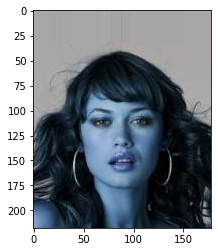

In [82]:
y_pred = model.predict(test_X)
y_pred_1 = y_pred[6]
test_x_1 = test_X[6]


plt.imshow(test_x_1)

y_pred_1

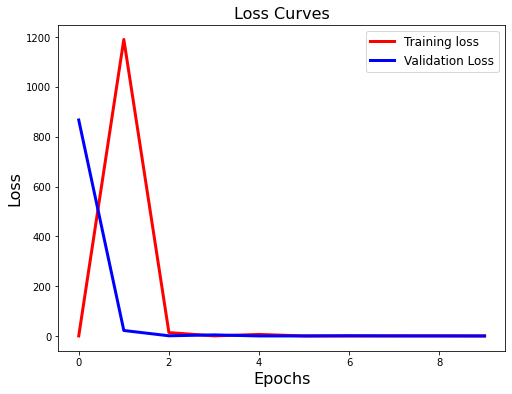

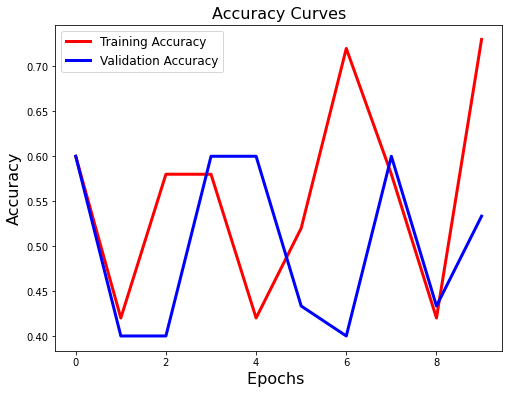

In [58]:
def plot_history(history):
    # Plot the Loss Curves
    plt.figure(figsize=[8,6])
    
    plt.plot(history.history['loss'], 'r', linewidth=3.0)
    plt.plot(history.history['val_loss'], 'b', linewidth=3.0)
    
    plt.legend(['Training loss', 'Validation Loss'], fontsize=12)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.title('Loss Curves', fontsize=16)
    
    # Plot the Accuracy Curves
    plt.figure(figsize=[8,6])
    
    plt.plot(history.history['accuracy'], 'r', linewidth=3.0)    
    plt.plot(history.history['val_accuracy'], 'b', linewidth=3.0)
    
    plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=12)
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.title('Accuracy Curves', fontsize=16)
    
plot_history(history)

### Presentation:

1. Introduce your task. What are you predicting or classifying?
    - We are predicting if the random picture is male or not
2. Describe your data and any insights from EDA
    - 
3. Describe your model (CNN or MLP). Why did you choose one over the other?
    - We 
4. Describe your results: Show model accuracies and explain if possible, demo a test prediction (i.e. select a random image from test set and show prediction)
    -